In [1]:
%matplotlib inline
from importlib import reload
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import product
from functools import partial
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.datasets.base import Bunch
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import GraphLasso, empirical_covariance
from sklearn.datasets.base import Bunch
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.gaussian_process import kernels

from regain import prox; reload(prox)
from regain.covariance import time_graphical_lasso_; reload(time_graphical_lasso_);
import time

from regain.bayesian import wishart_process_; reload(wishart_process_)
from regain.bayesian import stats; reload(stats)

from regain import utils; reload(utils);


In [2]:
def base_results(mdl, X, y, K, K_obs, ells, search_spaces=None, **params):
    ll = mdl.set_params(**params)

    tic = time.time()
    if search_spaces is None:
        ll.fit(X, y)
    else:
        ll = use_bscv(ll, search_spaces, X, y)
    tac = time.time()

    ss = utils.structure_error(K, ll.precision_)
    MSE_precision = utils.error_norm(K, ll.precision_, upper_triangular=True)

    res = dict(
        n_dim_obs=K.shape[1], time=tac - tic, iterations=ll.n_iter_,
        MSE_precision=MSE_precision, estimator=ll, likelihood=ll.score(X, y))

    if hasattr(ll, 'latent_'):
        res['MSE_observed'] = utils.error_norm(
            K_obs, ll.precision_ - ll.latent_)
        res['MSE_latent'] = utils.error_norm(ells, ll.latent_)
        res['mean_rank_error'] = utils.error_rank(ells, ll.latent_)

    res = dict(res, **ss)
    return res

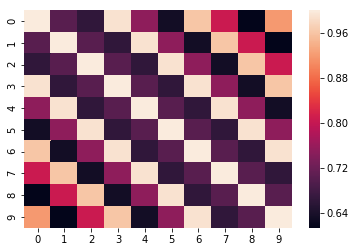

In [3]:
import seaborn as sns
# kernel used to generate data
sns.heatmap(kernels.ExpSineSquared(periodicity=np.pi,
                                      length_scale=2)(np.arange(10)[:,None]))


In [4]:

# setting 1
n_samples = 100
T = 10
n_dim_obs = 5

k = (n_dim_obs, T)

np.random.seed(0)

reload(datasets)
data = {(dim, T) : datasets.make_dataset(
    mode='sin', shape='smooth',
    update_theta='l2', normalize_starting_matrices=False,
    n_samples=n_samples, n_dim_lat=0, n_dim_obs=dim,  T=T, epsilon=1e-1,
    proportional=True, degree=2, keep_sparsity=True)
    for dim in [n_dim_obs]}

NameError: name 'datasets' is not defined

In [ ]:
data

In [ ]:
# info on the data set
K = data[(5, 10)].thetas
print ("Percentual of non-zero components at each time: {}".format(
    [(i!=0).sum() / i.size for i in K]))

print ("Percentual of total non-zero components: {}".format(
    (K != 0).sum() / (n_dim_obs ** 2 * T)))

In [ ]:
d

In [ ]:
# run_results(data[:2], dff, scores)

idx = pd.IndexSlice
for i, res in enumerate(data.values()):
    #if i > 5 or i < 2: continue
    # dim = k[0]
    data_list = res.data
    K = res.thetas
    K_obs = res.thetas_observed
    ells = res.ells
    # to use it later for grid search
    data_grid = np.array(data_list).transpose(1, 2, 0)
    T = data_list.shape[0]
    print("Start with: dim=%d, T=%d (it %d)" % (data_list.shape[-1], T, i))

In [ ]:
import regain.generalized_linear_model.time; reload(regain.generalized_linear_model.time)
from regain.generalized_linear_model.time import TemporalGraphicalModel
mdl = TemporalGraphicalModel(distribution='gaussian',
        alpha=0.5, psi='laplacian', assume_centered=0, rtol=1e-5, tol=1e-5,
        max_iter=1000, rho=1. / np.sqrt(data_list.shape[1]),
        update_rho_options=dict(mu=5), kernel=partial(
            kernels.ExpSineSquared, periodicity=np.pi), ker_param=2)

X = np.vstack(data_list)
y = np.array([np.ones(x.shape[0]) * i
              for i, x in enumerate(data_list)]).flatten().astype(int)
base_results(mdl, X, y, K, K_obs, ells, search_spaces=None)

# ISING

In [ ]:
from regain._datasets.ising import ising_theta_generator

thetas = ising_theta_generator(p=5, n=100, T=10, mode='l1', time_on_axis='first',
          change=4, responses=[-1,1])


In [ ]:
from regain.generalized_linear_model.sampling import ising_sampler

np.array([ising_sampler(t, np.zeros(5), n=100,
                        responses=[-1,1]) for t in thetas])

In [5]:
#devo generare dati temporali.. nel dubbio potrei farli tutti uguali, per cominciare
#import regain.datasets.time; reload(regain.datasets.time)
import regain._datasets.ising; reload(regain._datasets.ising)
import regain.datasets; reload(regain.datasets)
from regain.datasets import make_dataset

samples, thetas = make_dataset(
        n_samples=100, n_dim_obs=5,  T=10,  update_theta='l1',
 distribution='ising', change=2)

l1


In [6]:
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
from regain.generalized_linear_model.ising import Ising_GLM_GM
ising_mdl = Ising_GLM_GM(alpha=0.25, mode='symmetric_fbs', verbose=0)
ising_mdl.fit(samples[3])

Ising_GLM_GM(alpha=0.25, compute_objective=True, max_iter=100,
       mode='symmetric_fbs', reconstruction='union', return_history=True,
       return_n_iter=False, rho=1, rtol=0.0001, tol=0.0001, verbose=0)

In [ ]:
thetas[0].shape

In [ ]:
utils.structure_error(np.array(thetas[3]), ising_mdl.precision_, no_diagonal=True)

In [ ]:
import regain.covariance.time_graphical_lasso_; reload(regain.covariance.time_graphical_lasso_)
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
import regain.generalized_linear_model.time; reload(regain.generalized_linear_model.time)
from regain.generalized_linear_model.time import TemporalGraphicalModel

kernel = np.ones((10,10))*1e-5
np.fill_diagonal(kernel, 1)
mdl = TemporalGraphicalModel(distribution='ising',
        alpha=10, psi='l1', assume_centered=0, rtol=1e-5, tol=1e-5,
        max_iter=300, rho=1.,
        update_rho_options=dict(mu=5), kernel=kernel, init='zeros', verbose=1)

X = np.vstack(samples)
y = np.array([np.ones(x.shape[0]) * i
              for i, x in enumerate(samples)]).flatten().astype(int)
#base_results(mdl, X, y, K, thetas, ells, search_spaces=None)

In [ ]:
mdl.fit(X, y)

In [ ]:
for p in mdl.precision_:
    plt.imshow(p)
    plt.colorbar()
    plt.show()

In [ ]:
ss = utils.structure_error(np.array(thetas), mdl.precision_, no_diagonal=True)
MSE_precision = utils.error_norm(np.array(thetas), mdl.precision_, upper_triangular=True)

In [ ]:
ss

In [ ]:
K.shape

In [ ]:
X.shape

In [ ]:
samples[0].shape

In [ ]:
len(samples)